<a href="https://colab.research.google.com/github/leonsuarez24/Notebooks/blob/main/Single_Pixel_Camera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
!pip install torchinfo
from torchinfo import summary

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
!pip install torchmetrics

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 35.9 MB/s eta 0:00:00


In [ ]:
# Prepare the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

print(trainset.data.size())
print(trainset.targets.size())
print(trainset.targets[12].item())

100%|██████████| 9912422/9912422 [00:00<00:00, 382231580.52it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 120653081.50it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 107719131.45it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20053188.18it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

torch.Size([60000, 28, 28])
torch.Size([60000])
3


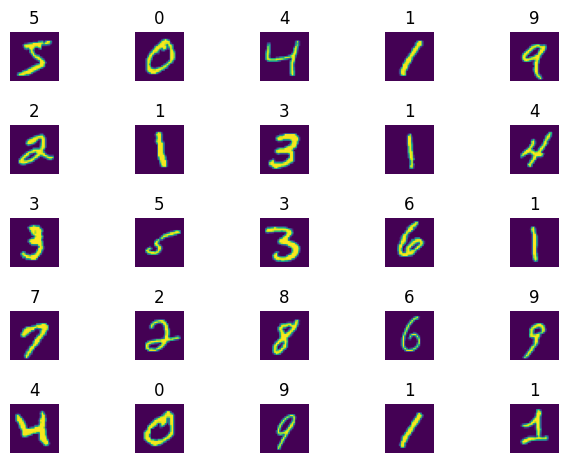

In [ ]:
fig, ax = plt.subplots(5, 5)
fig.tight_layout()

k = 0
for i in range(5):
  for j in range(5):
    ax[i, j].imshow(trainset.data[k])
    ax[i, j].set_title(f"{trainset.targets[k]}")
    ax[i, j].axis('off')
    k +=1

plt.show()

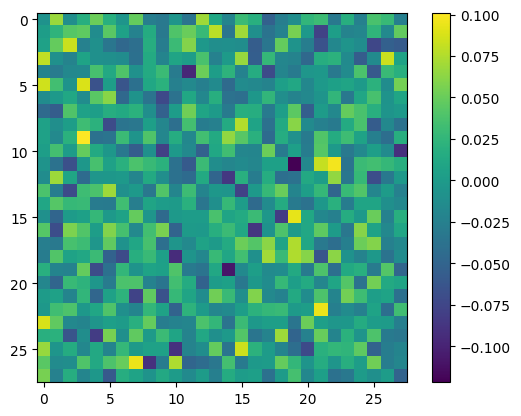

tensor(0.0349) tensor(7.1780e-05)


In [ ]:
ca = (torch.normal(0, 1, (10, 28, 28))/ np.sqrt(28*28))
plt.imshow(ca[0,:,:])
plt.colorbar()
plt.show()
print(torch.std(ca[0]), torch.mean(ca[0]))

In [ ]:
class OpticalLayer(nn.Module):
    def __init__(self, K, output_dim, input_dim):
        super(OpticalLayer, self).__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.K = K
        ca = torch.normal(0, 1, (self.K, self.output_dim, self.input_dim))
        self.weights = nn.Parameter(ca / np.sqrt(self.output_dim * self.input_dim))
        #torch.nn.init.normal_(self.weights, mean=0.0, std=0.04)

    def forward(self, x):
        # Downscale to 1 px
        ca_w = torch.unsqueeze(self.weights, 0)
        x = torch.mul(x, ca_w)
        x = torch.sum(x, dim=(-2, -1))
        x = torch.unsqueeze(x, -1)
        x = torch.unsqueeze(x, -1)
        # Upscale to 28x28
        x = torch.mul(x, ca_w)
        x = torch.sum(x, dim=1)
        x = torch.unsqueeze(x, 1)
        x = x / torch.max(x)
        return x

In [ ]:
ol = OpticalLayer(160,28,28).to(device)
summary(ol, input_size=(32, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
OpticalLayer                             [32, 1, 28, 28]           125,440
Total params: 125,440
Trainable params: 125,440
Non-trainable params: 0
Total mult-adds (M): 4.01
Input size (MB): 0.10
Forward/backward pass size (MB): 0.20
Params size (MB): 0.50
Estimated Total Size (MB): 0.80

In [ ]:
class SinglePixelCamera(nn.Module):
  def __init__(self, K, output_dim, input_dim):
    super(SinglePixelCamera, self).__init__()
    self.optical_layer = OpticalLayer(K, output_dim, input_dim)
    self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64 * 3 * 3, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.optical_layer(x)
    x = nn.functional.relu(self.conv1(x)) #28x28
    x = self.pool(x) #14x14
    x = nn.functional.relu(self.conv2(x)) #14x14
    x = self.pool(x) #7x7
    x = nn.functional.relu(self.conv3(x)) #7x7
    x = self.pool(x) #3x3
    x = x.view(-1, 64 * 3 * 3)
    x = nn.functional.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
spc = SinglePixelCamera(160,28,28).to(device)
summary(spc, (32,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
SinglePixelCamera                        [32, 10]                  --
├─OpticalLayer: 1-1                      [32, 1, 28, 28]           125,440
├─Conv2d: 1-2                            [32, 32, 28, 28]          320
├─MaxPool2d: 1-3                         [32, 32, 14, 14]          --
├─Conv2d: 1-4                            [32, 64, 14, 14]          18,496
├─MaxPool2d: 1-5                         [32, 64, 7, 7]            --
├─Conv2d: 1-6                            [32, 64, 7, 7]            36,928
├─MaxPool2d: 1-7                         [32, 64, 3, 3]            --
├─Linear: 1-8                            [32, 128]                 73,856
├─Linear: 1-9                            [32, 10]                  1,290
Total params: 256,330
Trainable params: 256,330
Non-trainable params: 0
Total mult-adds (M): 188.36
Input size (MB): 0.10
Forward/backward pass size (MB): 10.67
Params size (MB): 1.03
Estimated Total Size

In [ ]:
print((torch.sum(torch.mul(torch.pow(1 + spc.optical_layer.weights, 2), torch.pow(1 - spc.optical_layer.weights, 2)))))

tensor(125119.5312, device='cuda:0', grad_fn=<SumBackward0>)


In [ ]:
def plot_images(images):
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    axes = axes.ravel()
    for i in range(len(images)):
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        axes[i].set_title(f'CA: {i + 1}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

def plot_images_labels(images, labels):
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    axes = axes.ravel()
    for i in range(len(images)):
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {labels[i]}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# Initialize the network and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(spc.parameters(), lr=0.001)
regularizer_parameter = 1e-3
# Training loop
for epoch in range(20):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()

    pred = spc(inputs)
    loss = criterion(pred, labels) + regularizer_parameter * (torch.sum(torch.mul(torch.pow(1 + spc.optical_layer.weights, 2), torch.pow(1 - spc.optical_layer.weights, 2))))

    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if (i + 1) % 375 == 0:  # Print the running loss every 375 mini-batches
      print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 375:.3f}')
      running_loss = 0.0

print('Training finished!')

Epoch: 1, Batch: 375, Loss: 124.155
Epoch: 1, Batch: 750, Loss: 115.007
Epoch: 1, Batch: 1125, Loss: 94.177
Epoch: 1, Batch: 1500, Loss: 61.737
Epoch: 1, Batch: 1875, Loss: 33.206
Epoch: 2, Batch: 375, Loss: 16.867
Epoch: 2, Batch: 750, Loss: 9.058
Epoch: 2, Batch: 1125, Loss: 5.277
Epoch: 2, Batch: 1500, Loss: 3.256
Epoch: 2, Batch: 1875, Loss: 2.095
Epoch: 3, Batch: 375, Loss: 1.375
Epoch: 3, Batch: 750, Loss: 0.954
Epoch: 3, Batch: 1125, Loss: 0.689
Epoch: 3, Batch: 1500, Loss: 0.533
Epoch: 3, Batch: 1875, Loss: 0.405
Epoch: 4, Batch: 375, Loss: 0.334
Epoch: 4, Batch: 750, Loss: 0.276
Epoch: 4, Batch: 1125, Loss: 0.247
Epoch: 4, Batch: 1500, Loss: 0.230
Epoch: 4, Batch: 1875, Loss: 0.204
Epoch: 5, Batch: 375, Loss: 0.197
Epoch: 5, Batch: 750, Loss: 0.180
Epoch: 5, Batch: 1125, Loss: 0.174
Epoch: 5, Batch: 1500, Loss: 0.174
Epoch: 5, Batch: 1875, Loss: 0.170
Epoch: 6, Batch: 375, Loss: 0.166
Epoch: 6, Batch: 750, Loss: 0.163
Epoch: 6, Batch: 1125, Loss: 0.157
Epoch: 6, Batch: 1500, L

In [ ]:
# Evaluation
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs= spc(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy on the test set: {100 * correct / total:.2f}%')


Accuracy on the test set: 96.18%


In [ ]:
spc.optical_layer.weights.shape

torch.Size([160, 28, 28])

torch.Size([160, 28, 28])


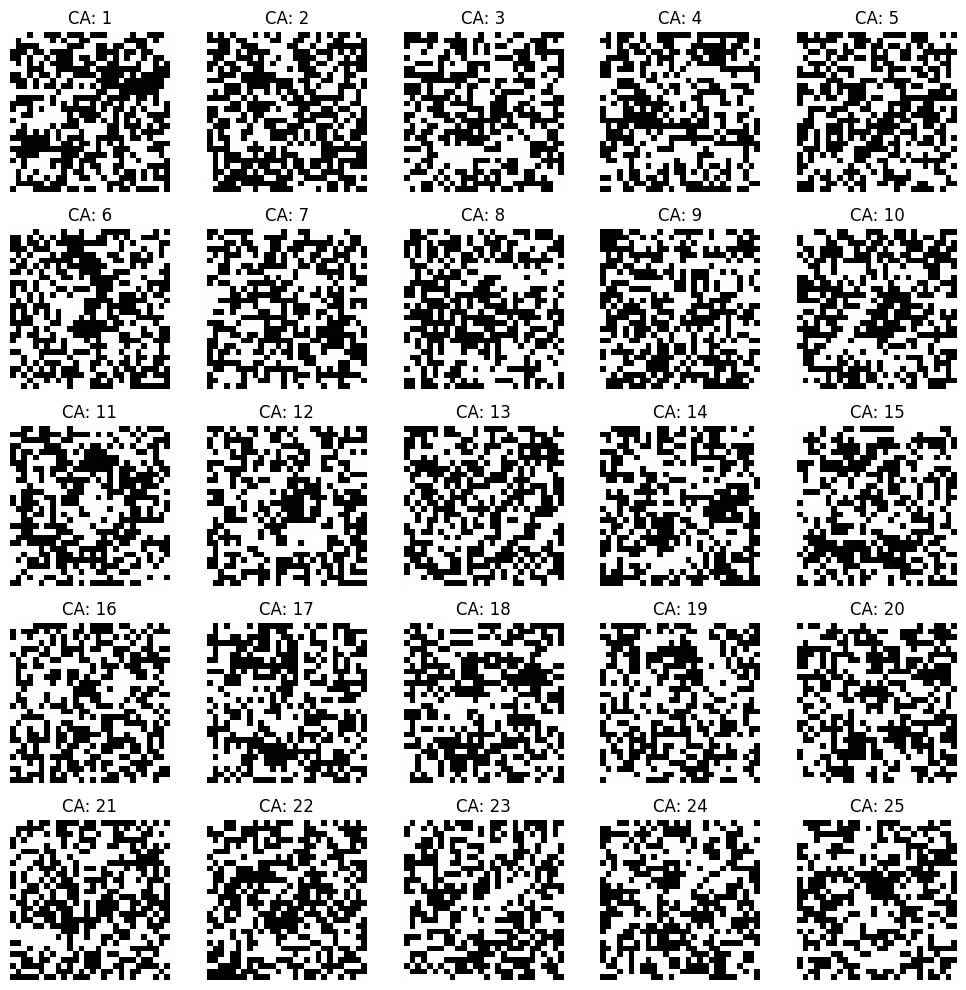

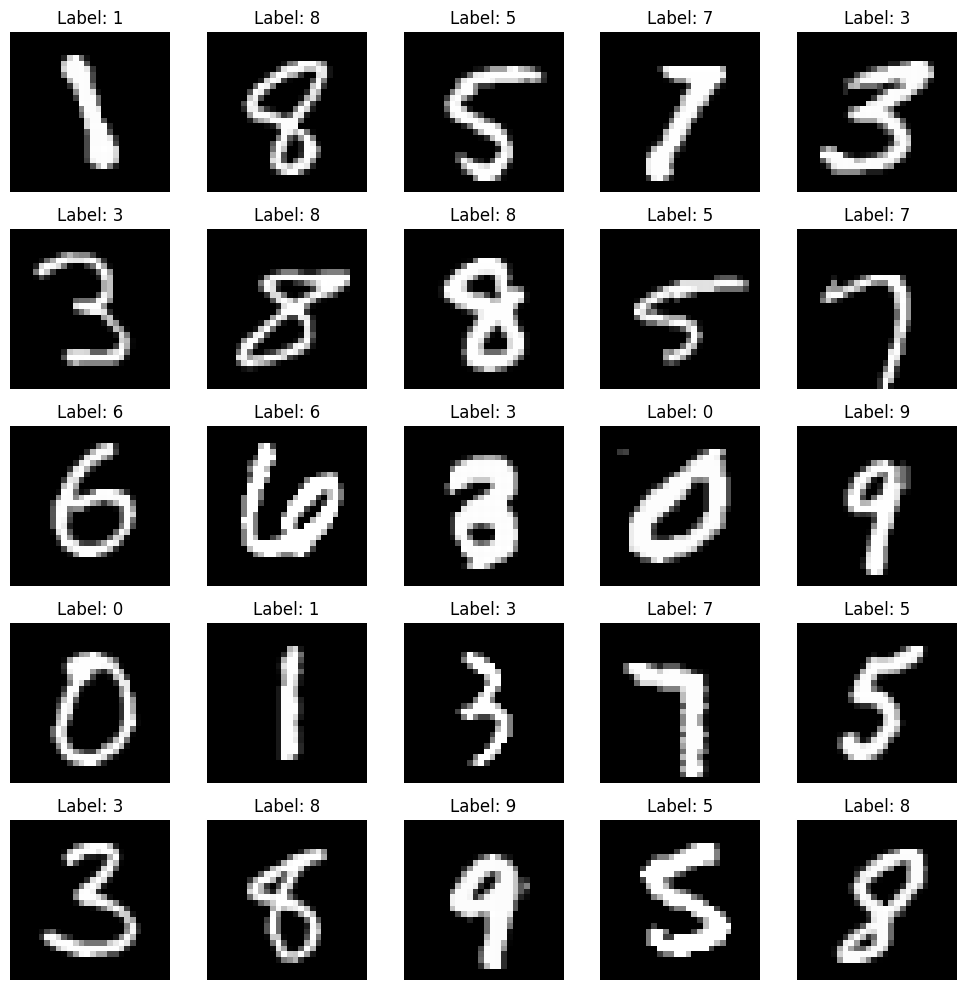

In [ ]:
subset_indices = torch.randint(0, len(testset), (25,))
subset_images = [testset[i][0] for i in subset_indices]
subset_labels = [testset[i][1] for i in subset_indices]
subset_images = torch.stack(subset_images).to(device)
spc.eval()
spc = spc.cpu()
subset_images = subset_images.cpu()

with torch.no_grad():
    outputs = spc(subset_images)
    _, predicted = torch.max(outputs, 1)
    print(spc.optical_layer.weights.shape)
    plot_images(spc.optical_layer.weights[:25,:,:])
    plot_images_labels(subset_images, predicted)